In [1]:
import os
import numpy as np
import pandas as pd
import sys
import pickle
from tqdm.notebook import tqdm, trange
import rdkit 
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pyplot as plt
import mols2grid
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
# import Virtuous Library
sys.path.append('../scripts/')
import Virtuous
print (Virtuous.__version__)

1.8


## Load DBs

In [3]:
# path to the file in the Dropbox folder 
data_path = "../data/"
dataset_file  = data_path + "train.pickle"

In [4]:
DB = pd.read_pickle(dataset_file)#,    sep=";", low_memory=False)

In [5]:
DB_train, DB_test = train_test_split(DB, test_size=0.1)

In [6]:
print ("Number of compounds in the original DB: %d" %DB.shape[0])
print ("\nNumber of compounds in the training set: %d" %DB_train.shape[0])
print ("Number of compounds in the testing  set: %d" %DB_test.shape[0])
print ("\nNumber of bitter compounds in the training set: %d" %(DB_train["Taste"]=="Bitter").sum())
print ("Number of bitter compounds in the testing  set: %d" %(DB_test["Taste"]=="Bitter").sum())
print ("\nNumber of sweet compounds in the training set: %d" %(DB_train["Taste"]=="Sweet").sum())
print ("Number of sweet compounds in the testing  set: %d" %(DB_test["Taste"]=="Sweet").sum())

Number of compounds in the original DB: 2195

Number of compounds in the training set: 1975
Number of compounds in the testing  set: 220

Number of bitter compounds in the training set: 1038
Number of bitter compounds in the testing  set: 114

Number of sweet compounds in the training set: 937
Number of sweet compounds in the testing  set: 106


In [7]:
DB_train = DB_train.reset_index()
DB_test  = DB_test.reset_index()

## Define the Applicability Domain of Umami DB

In [8]:
AD_train = Virtuous.DefineAD(DB_train, smile_field="Parent_SMILES", output_filename= data_path + "bittersweet_AD_train1.pkl")

#### Define number of neighbors

In [9]:
vicini = 5
metric = "tanimoto"

## Retrieve threshold for the AD definition

#### Training-Training comparison

In [10]:
train_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_train))):
        
    # calculate §average similarity score of all umami compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_train.Parent_SMILES[i], filename= data_path + "bittersweet_AD_train1.pkl", verbose = False, neighbors = vicini, metric=metric) 
    train_scores.append(score)

  0%|          | 0/1975 [00:00<?, ?it/s]

#### Training-Testing comparison

In [11]:
test_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_test))):
        
    # calculate §average similarity score of all umami compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_test.Parent_SMILES[i], filename=data_path + "bittersweet_AD_train1.pkl", verbose = False, neighbors = vicini, metric = metric) 
    test_scores.append(score)

  0%|          | 0/220 [00:00<?, ?it/s]

#### Plot Scores

In [12]:
all_scores = train_scores + test_scores

index_train = ["Train vs Train"] * len(train_scores)
index_test  = ["Test vs Train"]  * len(test_scores)
all_index   = index_train + index_test

df = pd.DataFrame()
df["data"] = all_scores
df["index"] = all_index

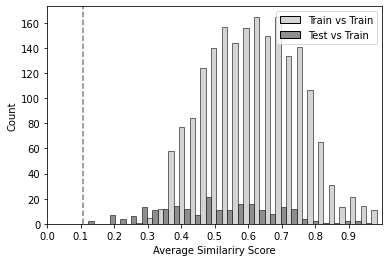

In [13]:
g = sns.histplot(data = df, x = "data", hue = "index", palette="Greys", multiple="dodge", shrink=1, stat = 'count')
g.legend_.set_title(None)
#plt.axvline(np.min(all_scores), 0, 60 , color='k', linestyle = '--')
plt.axvline(np.min(all_scores), 0, 60 , color='grey', linestyle = '--')
plt.xlabel("Average Similariry Score")
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))
plt.savefig(data_path + "AD_Train_vs_Test1.png", dpi=300)
plt.show()

- ***Similar distribution between Training and Dataset, showing that the dataset is pretty similar to the training set distribution***

In [14]:
threshold = np.around(np.min(all_scores), decimals=2)
print (f'Setting similarity threshold to {threshold}')

Setting similarity threshold to 0.11


## Import query molecule

In [15]:
query_smile = "C(C1C(C(C(C(O1)O)O)O)O)O" #glucose
query_smile = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C" # caffeine
#query_smile =  "C(CC(=O)[O-])C(C(=O)[O-])[NH3+]"# glutammate

issues, std_smi, parent_smi = Virtuous.Standardize(Virtuous.ReadMol(query_smile, verbose=False))
mols = [Virtuous.ReadMol(query_smile, verbose=False), Virtuous.ReadMol(std_smi, verbose=False), Virtuous.ReadMol(parent_smi, verbose=False)]
mols2grid.display(mols, fixedBondLength=60, template="table", fontsize="10pt", legend=["original", "standard", "parent"])

### Test the AD: calculate Similarities between query compound and Umami DB

In [16]:
test, score, sim_smiles = Virtuous.TestAD(query_smile, filename=data_path + "bittersweet_AD_train.pkl", verbose = True, sim_threshold=threshold, neighbors = vicini, metric = metric)
print ("Score is: %.3f" %score)

OK: The query compound is inside the Applicability Domain!
Score is: 0.607


In [17]:
mols = [Virtuous.ReadMol(smile, verbose=False) for smile in sim_smiles]
mols2grid.display(mols, fixedBondLength=60, template="table", fontsize="10pt")

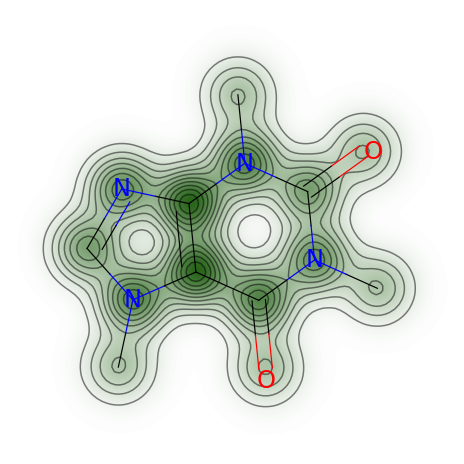

In [18]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], Virtuous.ReadMol(parent_smi, verbose=False), SimilarityMaps.GetMorganFingerprint)

In [19]:
print ("The 5 most similar compounds in the DB result in an average similarity score of %.2f and they are \n%s" %(score, sim_smiles))

The 5 most similar compounds in the DB result in an average similarity score of 0.61 and they are 
['Cn1c(=O)c2c(ncn2C)n(C)c1=O' 'CC(=O)CCCCn1c(=O)c2c(ncn2C)n(C)c1=O'
 'Cn1cnc2c1c(=O)[nH]c(=O)n2C' 'Cn1c(=O)c2c(ncn2CC(O)CO)n(C)c1=O'
 'Cn1c(=O)c2c(nc[nH]2)n(C)c1=O']
